# Extraction of the pore network

First check if the proper packages are installed:

In [1]:
import numpy as np
assert np.__version__=='1.20.0',"Please note that this code is only tested on numpy 1.20"
# this code is tested on porespy 1.3.1 and openpnm 2.8.2
import porespy as ps
assert ps.__version__=='1.3.1',"Please note that this code is only tested on porespy 1.3.1"
from porespy.networks import regions_to_network, add_boundary_regions
from porespy.networks import _net_dict
from porespy.networks import label_boundary_cells
from porespy.tools import pad_faces
from porespy.tools import make_contiguous
from porespy.metrics import region_surface_areas, region_interface_areas
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import openpnm as op
assert op.__version__ == '2.8.2',"Please note that this code is only tested on openpnm 2.8.2"
import scipy as sp
from skimage import io
from skimage.morphology import binary_dilation
import pickle

Create a new workspace for the openpnm

In [18]:
ws = op.Workspace()
ws.clear()

Importing the image into the code

In [22]:
fname = 'DRP_Berea_400x400x400_3pt4um_Ilastik_Segmented.tiff'
im = io.imread(fname)

im = im > 1
imtype=im.view()
im = sp.array(im, dtype=bool)
im = ~im #it may be commented on some samples (0,1 inversion of binarized image
# to represent 1 for pores and 0 for solids)
im = im.T
print('Initial Porosity:')
print(ps.metrics.porosity(im))
# im=ps.filters.trim_floating_solid(im)
# print('Porosity after removing disconnected matrix:')
# print(ps.metrics.porosity(im))
# im = ps.filters.fill_blind_pores(im)
# print('Porosity after filling in the blind pores:')
# print(ps.metrics.porosity(im))

<ipython-input-22-39c1ed3691b6>:6: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
  im = sp.array(im, dtype=bool)


Initial Porosity:
0.249404125


Find the porosity of a slice

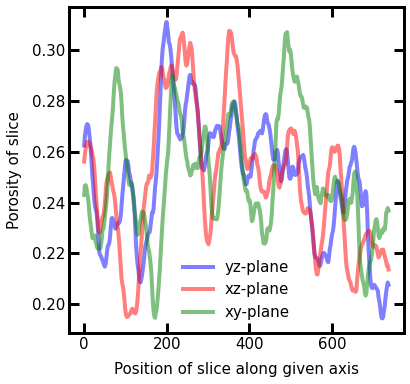

In [25]:
ps.visualization.set_mpl_style()
voxel_size = 1.843803  # microns/voxel
x_profile = ps.metrics.porosity_profile(im, 0)
y_profile = ps.metrics.porosity_profile(im, 1)
z_profile = ps.metrics.porosity_profile(im, 2)
plt.figure(figsize=[6, 6])
plt.plot(np.linspace(0, im.shape[0]*voxel_size, im.shape[0]), x_profile, 'b-', label='yz-plane', alpha=0.5)
plt.plot(np.linspace(0, im.shape[1]*voxel_size, im.shape[1]), y_profile, 'r-', label='xz-plane', alpha=0.5)
plt.plot(np.linspace(0, im.shape[2]*voxel_size, im.shape[2]), z_profile, 'g-', label='xy-plane', alpha=0.5)
plt.ylabel('Porosity of slice')
plt.xlabel('Position of slice along given axis')
plt.legend()
plt.show()

Partitioning the image into different regions

In [26]:
voxel_size=1.843803e-6 #meters
boundary_faces=['top', 'bottom', 'left', 'right', 'front', 'back']
marching_cubes_area=False
r_max = 5
sigma = 0.35
# -------------------------------------------------------------------------
# SNOW void phase
regions = ps.filters.snow_partitioning(im=im,  r_max=r_max, sigma=sigma, return_all=True)

------------------------------------------------------------
Beginning SNOW Algorithm
Converting supplied image (im) to boolean
Peforming Distance Transform
Applying Gaussian blur with sigma = 0.35
Initial number of peaks:  3232
Peaks after trimming saddle points:  2359
Peaks after trimming nearby peaks:  2352


Plot Output results

<ipython-input-28-e11ee47cbd1d>:8: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  cmap.set_bad('red', 1.)


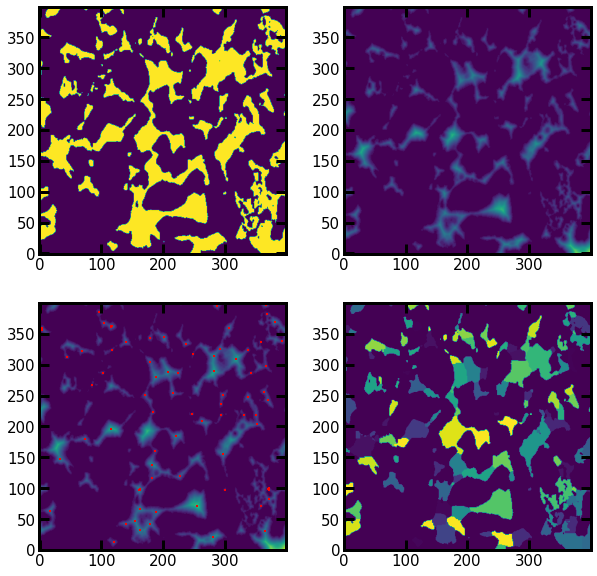

Number of regions: 2353


In [28]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[10, 10])
ax1.imshow(regions.im[1,:,:], origin='lower')
ax2.imshow(regions.dt[1,:,:], origin='lower')
dt_peak = regions.dt.copy()
peaks_dilated = binary_dilation(regions.peaks > 0)
dt_peak[peaks_dilated > 0] = np.nan
cmap = cm.viridis
cmap.set_bad('red', 1.)
ax3.imshow(dt_peak[1,:,:], origin='lower', cmap=cmap)
ax4.imshow(regions.regions[1,:,:], origin='lower')
plt.show()
print(f"Number of regions: {np.unique(regions.regions).size}")

 Use regionprops_3d to analyze properties of each pore

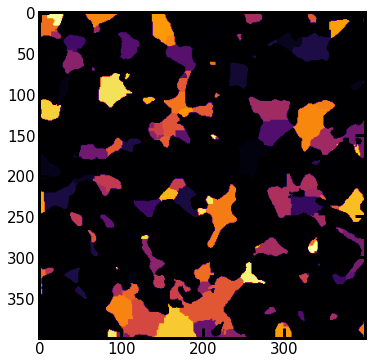

In [29]:
regions_temp = regions.regions*regions.im
plt.subplots(1, 1, figsize=(6, 6))
# have a look on the slice that you want
fig = plt.imshow(regions_temp[:,:,250], cmap=plt.cm.inferno)

Generting regions 3D properties and Listing available props (Heavier Computation needed)

In [30]:
props = ps.metrics.regionprops_3D(regions_temp)
r = props[0]
attrs = [a for a in r.__dir__() if not a.startswith('_')]
print(attrs)

------------------------------------------------------------
Calculating regionprops


  0%|          | 0/2352 [00:00<?, ?it/s]C:\Users\omidreza\Anaconda3\lib\site-packages\porespy\metrics\__regionprops__.py:211: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  verts, faces, norms, vals = marching_cubes_lewiner(volume=tmp, level=0)
100%|██████████| 2352/2352 [02:45<00:00, 14.22it/s]

['label', 'slice', 'volume', 'bbox_volume', 'border', 'inscribed_sphere', 'surface_mesh_vertices', 'surface_mesh_simplices', 'surface_area', 'sphericity', 'skeleton', 'convex_volume', 'area', 'bbox', 'bbox_area', 'centroid', 'convex_area', 'convex_image', 'coords', 'eccentricity', 'equivalent_diameter', 'euler_number', 'extent', 'feret_diameter_max', 'filled_area', 'filled_image', 'image', 'inertia_tensor', 'inertia_tensor_eigvals', 'intensity_image', 'local_centroid', 'max_intensity', 'mean_intensity', 'min_intensity', 'major_axis_length', 'minor_axis_length', 'moments', 'moments_central', 'moments_hu', 'moments_normalized', 'orientation', 'perimeter', 'perimeter_crofton', 'solidity', 'weighted_centroid', 'weighted_local_centroid', 'weighted_moments', 'weighted_moments_central', 'weighted_moments_hu', 'weighted_moments_normalized']


Analyze properties for a single region (only works in case of a 2D image)

Solidity: 0.574


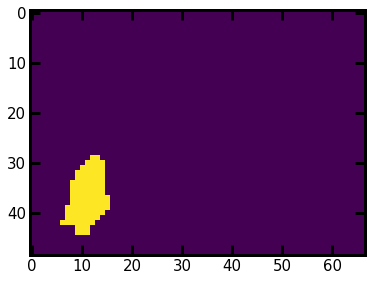

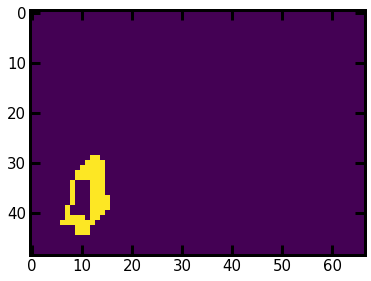

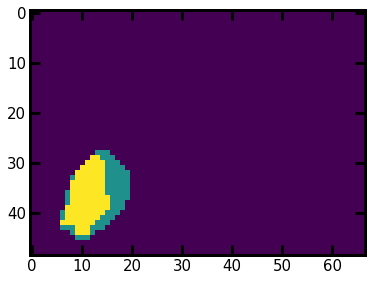

In [35]:
plt.subplots(1, 1, figsize=(6, 6))
plt.imshow(r.image[:,:,1])
plt.subplots(1, 1, figsize=(6, 6))
plt.imshow(r.border[:,:,1] + 0.5*r.inscribed_sphere[:,:,1])
plt.subplots(1, 1, figsize=(6, 6))
fig = plt.imshow(r.image[:,:,1] + 1.0*r.convex_image[:,:,1])
print(f"Solidity: {r.solidity:.3f}")

Extracting one property for all regions

label                       1.000000
volume                  22238.000000
bbox_volume            128037.000000
surface_area             7344.743164
sphericity                  0.520681
convex_volume           38713.000000
area                    22238.000000
bbox_area              128037.000000
convex_area             38713.000000
equivalent_diameter        34.889845
euler_number                1.000000
extent                      0.173684
feret_diameter_max         70.334913
filled_area             22238.000000
major_axis_length          70.471741
minor_axis_length          40.025189
solidity                    0.574432
Name: 0, dtype: float64

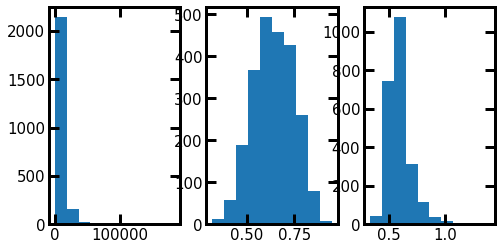

In [36]:
df = ps.metrics.props_to_DataFrame(props)
plt.figure(figsize=[8, 4])
plt.subplot(1, 3, 1)
fig = plt.hist(df['volume'])
plt.subplot(1, 3, 2)
fig = plt.hist(df['solidity'])
plt.subplot(1, 3, 3)
fig = plt.hist(df['sphericity'])
df.iloc[0]

Create a composite image of region images (create an image of maximally inscribed spheres)

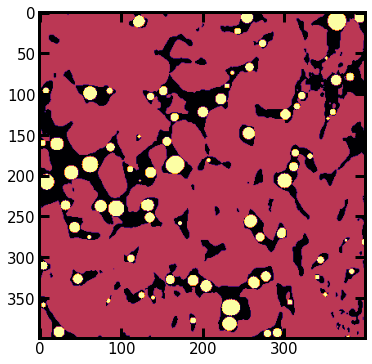

In [39]:
sph = ps.metrics.props_to_image(regionprops=props, shape=im.shape, prop='inscribed_sphere')
plt.subplots(1, 1, figsize=(6, 6))
fig = plt.imshow(sph[15,:,:] + 0.5*(~im[15,:,:]) , cmap=plt.cm.inferno)
plt.show()

Creating a colorized image based on region properties (Create an image colorized by solidity)

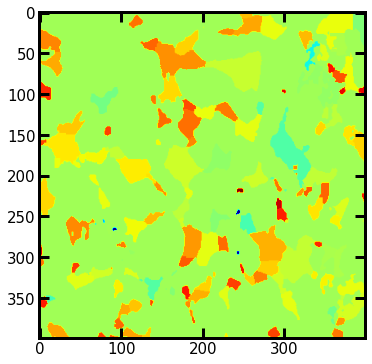

In [40]:
sph = ps.metrics.props_to_image(regionprops=props, shape=im.shape, prop='solidity')
plt.subplots(1, 1, figsize=(6, 6))
fig = plt.imshow(sph[1,:,:] + 0.5*(~im[1,:,:]) , cmap=plt.cm.jet)

Continue with the rest of SNOW extraction

In [41]:
im = regions.im
dt = regions.dt
regions = regions.regions
b_num = sp.amax(regions)
# -------------------------------------------------------------------------
# Boundary Conditions
regions = add_boundary_regions(regions=regions, faces=boundary_faces)
# -------------------------------------------------------------------------
# Padding distance transform and image to extract geometrical properties
dt = pad_faces(im=dt, faces=boundary_faces)
im = pad_faces(im=im, faces=boundary_faces)
regions = regions*im
regions = make_contiguous(regions)
# -------------------------------------------------------------------------
# Extract void and throat information from image
net = regions_to_network(im=regions, dt=dt, voxel_size=voxel_size)
# -------------------------------------------------------------------------
# Extract marching cube surface area and interfacial area of regions
if marching_cubes_area:
    areas = region_surface_areas(regions=regions)
    interface_area = region_interface_areas(regions=regions, areas=areas,
                                            voxel_size=voxel_size)
    net['pore.surface_area'] = areas * voxel_size**2
    net['throat.area'] = interface_area.area
# -------------------------------------------------------------------------
# Find void to void connections of boundary and internal voids
boundary_labels = net['pore.label'] > b_num
loc1 = net['throat.conns'][:, 0] < b_num
loc2 = net['throat.conns'][:, 1] >= b_num
pore_labels = net['pore.label'] <= b_num
loc3 = net['throat.conns'][:, 0] < b_num
loc4 = net['throat.conns'][:, 1] < b_num
net['pore.boundary'] = boundary_labels
net['throat.boundary'] = loc1 * loc2
net['pore.internal'] = pore_labels
net['throat.internal'] = loc3 * loc4
# -------------------------------------------------------------------------
# label boundary cells
net = label_boundary_cells(network=net, boundary_faces=boundary_faces)
# -------------------------------------------------------------------------
# assign out values to dummy dict

temp = _net_dict(net)
temp.im = im.copy()
temp.dt = dt
temp.regions = regions
net = temp

<ipython-input-41-e96b7a223e95>:4: DeprecationWarning: scipy.amax is deprecated and will be removed in SciPy 2.0.0, use numpy.amax instead
  b_num = sp.amax(regions)


------------------------------------------------------------
Extracting pore and throat information from image
100%|██████████| 3114/3114 [00:37<00:00, 82.51it/s] 


Save the network as an openpnm object

In [45]:
pn = op.network.GenericNetwork()
pn.update(net)
prj = pn.project

Removing the isolated pores

In [46]:
a = pn.check_network_health()
op.topotools.trim(network=pn,pores=a['trim_pores'])

Save a vtk file which can be read by paraview

In [47]:
# int(sigma*100) is because file names have problems with '.'
# fname = 'Berea700_r'+str(r_max)+'_sigma'+str(int(sigma*100))
# prj.export_data(filename=fname, filetype='vtk')

Save the image to overlay it the original image with paraview

In [48]:
#im = ps.tools.align_image_with_openpnm(im).astype(int)
#ps.io.to_vtk(im, path='Berea700_r'+str(r_max)+'_sigma'+str(sigma))

Save a pore network to be read later

In [51]:
# normal pickle dump (problem is large file size)
# pickle.dump(net, open( fname+'.dict', "wb" ) )

# Pickle a file and then compress it into a file with extension 
import bz2
import _pickle as cPickle
def compressed_pickle(title, data):
    with bz2.BZ2File(title + '.pbz2', 'w') as f: 
        cPickle.dump(data, f)
compressed_pickle(fname, net)